In [1]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import torch
import resampy
import librosa
import random

from torch.autograd import backward
from kymatio.torch import TimeFrequencyScattering1D

from utils import generate_harmonic_signal, chirp

SAMPLE_RATE = 22050

ModuleNotFoundError: No module named 'torch'

### Create the filterbank

In [71]:
N = 2**17
jtfs = TimeFrequencyScattering1D(
    J = 8, 
    shape = (N, ), 
    Q = 12, 
    T = None, 
    max_pad_factor=1,
    max_pad_factor_fr=1,
    average_fr = False,
).cuda()

### Gradient Descent

In [72]:
import time

def reconstruct(x, 
                lr = 100, 
                n_iter = 200, 
                bold_driver_accelerator = 1.1, 
                bold_driver_brake = 0.55):
    start = time.time()

    err_history = []

    torch.manual_seed(0)
    noise = torch.randn((N,), requires_grad=True)
    S_noise = jtfs(noise.cuda())

    target = torch.from_numpy(x)
    S_target = jtfs(target.cuda())

    for i in range(n_iter):
        err = torch.norm(S_noise - S_target)

        if i % 10 == 0:
            print('Iteration %3d, loss %.2f' % (i, err.cpu().detach().numpy()))

        err_history.append(err)
        err.backward() # backward pass

        # gradient descent
        delta_y = noise.grad
        with torch.no_grad():
            noise_new = noise - lr * delta_y
        noise_new.requires_grad = True       

        if err_history[i] > err_history[i - 1]:
            lr *= bold_driver_brake
        else:
            lr *= bold_driver_accelerator
            noise = noise_new

        S_noise = jtfs(noise) # forward pass

    end = time.time()
    print(end-start)
    return target, noise

def plot_spectrograms(target, noise, Fs=22050):
    plt.figure(figsize=(8, 2))
    plt.plot(noise.detach().numpy())
    plt.title("Reconstructed signal")

    plt.figure(figsize=(8, 8))
    plt.specgram(target, Fs=Fs)
    plt.title("Spectrogram of original signal")

    plt.figure(figsize=(8, 8))
    plt.specgram(noise.detach().numpy(), Fs=Fs)
    plt.title("Spectrogram of reconstructed signal")

    plt.show()

## colored noise generation

In [38]:
import random
import numpy as np
import soundfile as sf
import IPython.display as ipd

In [22]:
a = np.random.rand(10)
a_ft = np.fft.fft(a)
a_rec = np.conj(np.fft.ifft(a_ft))
print(a,a_rec)

[0.7550103  0.51612437 0.87472056 0.45204134 0.73429494 0.47399154
 0.14300203 0.32219906 0.43659515 0.25017792] [0.7550103 +1.11022302e-17j 0.51612437+2.22044605e-17j
 0.87472056+1.16572503e-17j 0.45204134-1.57501281e-17j
 0.73429494-6.30567970e-17j 0.47399154-2.00370049e-18j
 0.14300203-4.47259184e-17j 0.32219906+6.24437509e-18j
 0.43659515+2.95120835e-17j 0.25017792+4.48161442e-17j]


In [49]:
signal,sr = sf.read("../audio/laughinggull.wav")
signal = np.mean(signal,axis=1)
N = len(signal)
print(N)
phasors = np.exp(2j*np.pi*np.random.rand(N//2-1))
colored_noise_ft = np.abs(np.fft.fft(signal))+0j
len_ft = len(colored_noise_ft)
print(len_ft,N)
colored_noise_ft[1:(len_ft//2)] = colored_noise_ft[1:(len_ft//2)]*phasors
colored_noise_ft[-1:(len_ft-len_ft//2):-1] = colored_noise_ft[-1:(len_ft-len_ft//2):-1]*np.conj(phasors)
colored_noise = np.fft.ifft(colored_noise_ft)

267561
267561 267561


In [50]:
def colored_noise(signal):
    N = len(signal)
    phasors = np.exp(2j*np.pi*np.random.rand(N//2-1))
    colored_noise_ft = np.abs(np.fft.fft(signal))+0j
    len_ft = len(colored_noise_ft)
    colored_noise_ft[1:(len_ft//2)] = colored_noise_ft[1:(len_ft//2)]*phasors
    colored_noise_ft[-1:(len_ft-len_ft//2):-1] = colored_noise_ft[-1:(len_ft-len_ft//2):-1]*np.conj(phasors)
    colored_noise = np.fft.ifft(colored_noise_ft)
    return colored_noise

In [58]:
x,sr = sf.read("../audio/media_accipiter.wav")
N = 2**int(np.floor(np.log(len(x))/np.log(2)))
N,sr

(65536, 22050)

In [51]:
signal,sr = sf.read("../audio/spiegel-patchwork.wav")
display(ipd.Audio(colored_noise(signal),rate=sr))
display(ipd.Audio(signal,rate=sr))

/Users/lilyh/anaconda3/envs/openl3/lib/python3.7/site-packages/IPython/lib/display.py:159: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


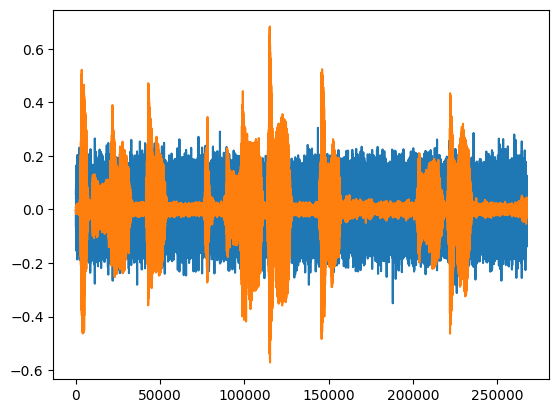

In [37]:
plt.plot(np.real(colored_noise))
plt.plot(signal)
plt.show()

In [52]:
np.log(2**13/22050*48000)/np.log(2)

14.122255750050998

In [55]:
2**14/48000,2**13/22050

(0.3413333333333333, 0.37151927437641724)

### Harmonic Signal

In [74]:
x = generate_harmonic_signal(N)
display(ipd.Audio(x, rate=SAMPLE_RATE, autoplay=True))

target, recon = reconstruct(x)
plot_spectrograms(target, recon)

Iteration   0, loss 472.07
Iteration  10, loss 82.86
Iteration  20, loss 59.76


KeyboardInterrupt: 

### Chirp Signal

Iteration   0, loss 504.19
Iteration  10, loss 54.36
Iteration  20, loss 28.29
Iteration  30, loss 22.71
Iteration  40, loss 20.62
Iteration  50, loss 19.47
Iteration  60, loss 19.77
Iteration  70, loss 18.18
Iteration  80, loss 17.52
Iteration  90, loss 17.03
Iteration 100, loss 17.10
Iteration 110, loss 16.42
Iteration 120, loss 16.30
Iteration 130, loss 16.13
Iteration 140, loss 15.85
Iteration 150, loss 15.72
Iteration 160, loss 15.62
Iteration 170, loss 15.50
Iteration 180, loss 15.16
Iteration 190, loss 15.06
89.3575165271759


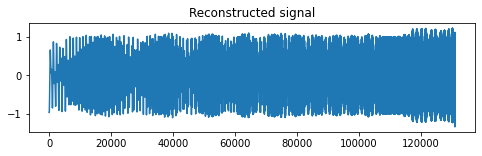

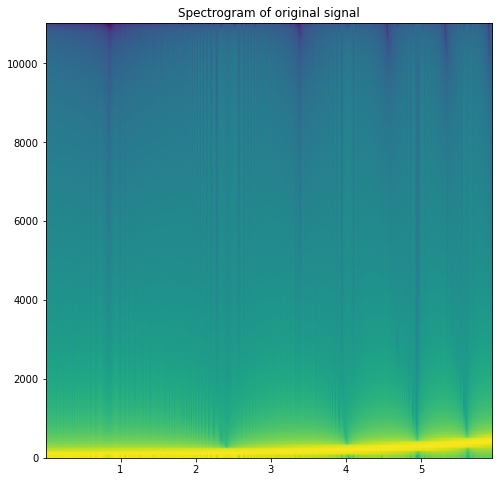

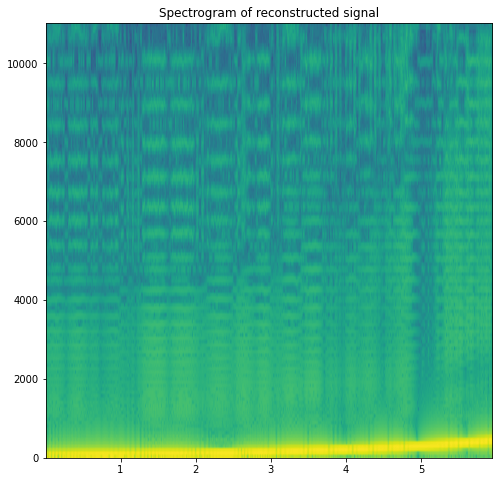

In [78]:
x = chirp(2**17, 30, 400, fs=SAMPLE_RATE, method='exp')

display(ipd.Audio(x, rate=SAMPLE_RATE, autoplay=True))

target, recon = reconstruct(x)
plot_spectrograms(target, recon)

In [80]:
display(ipd.Audio(recon.detach().numpy(), rate=SAMPLE_RATE, autoplay=True))
